In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

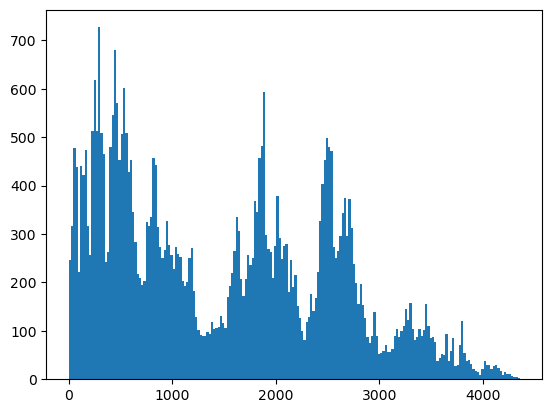

In [2]:
import math
import numpy as np
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.stats import poisson
from patsy import dmatrices
import statsmodels.graphics.tsaplots as tsa
from matplotlib import pyplot as plt
from statsmodels.tools.numdiff import approx_hess1, approx_hess2, approx_hess3
import pandas as pd

df = pd.read_csv('D:/data/Zircons/Roberts_Spencer_2015.csv')
ages = df["U-Pb (Ma)"]
data = plt.hist(ages, bins = 200)

In [3]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.1.2


In [4]:
zircons_data = data[0]
ages = data[1][1:]
print(len(ages))

200


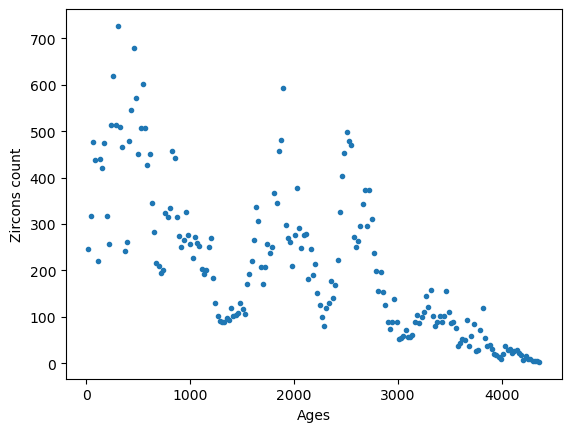

In [5]:
plt.plot(ages, zircons_data, "o", markersize=3, alpha=1)
plt.ylabel("Zircons count")
plt.xlabel("Ages");

In [6]:
ages_nominal = np.arange(len(ages))

In [13]:
#k=3 , n=200
#读取用来查的表switchPointList

switchPointList = []

import csv

f = open('3_200.csv', 'r')

with f:

    reader = csv.reader(f)

    for row in reader:
        temp = []
        for e in row:
            temp.append(int(e)) 
        if(temp != []):
            switchPointList.append(temp)
print(len(switchPointList))

1313400


In [14]:
print(switchPointList[0])

[1, 2, 3]


In [28]:
from pytensor.compile.ops import as_op
import pytensor.tensor as at

@as_op(itypes=[at.lscalar, at.dvector], otypes=[at.dvector])
def rate_(index, rates):
    rate = np.zeros(len(ages_nominal))
    
    switchPoints = switchPointList[index]
    
    rate[:switchPoints[0]] = rates[0]
    rate[switchPoints[0]:switchPoints[1]] = rates[1]
    rate[switchPoints[1]:switchPoints[2]] = rates[2]
    rate[switchPoints[2]:] = rates[3]
    return rate

In [29]:
with pm.Model() as zircons_model:
    
    k = 3
    # Priors for numbers of switch point
    #k = pm.DiscreteUniform("k",lower = 1, upper = max)
    # Priors for switch point
    

    #lowers = pm.math.constant(ages_nominal.min(),ndim = k)
    #uppers = pm.math.constant(ages_nominal.max(),ndim = k)
    #switchpoint = pm.DiscreteUniform("switchpoint", lower=lowers, upper=uppers)
    
    index = pm.DiscreteUniform("index", lower = 0, upper = len(switchPointList))
    rates = pm.Exponential("rates",1.0,shape = k+1)
    rate = rate_(index, rates)
    
    # Priors for pre- and post-switch rates number of disasters
    #early_rate = pm.Exponential("early_rate", 1.0)
    #late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    #rate = pm.math.switch(switchpoint >= ages_nominal, early_rate, late_rate)
    #index = 0
    #for i in range(k):
        #index += pm.math.switch(switchpoint >= rates[i], 1, 0)
    #rate = rates[index]
    #rate = rates[0]
    #for i in range(k):
        #rate = pm.math.switch(newswitchpoint[i] >= ages_nominal, rate, rates[i+1])
        
    disasters = pm.Poisson("counts", rate, observed=zircons_data)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [rates]
>Metropolis: [index]


E:\anaconda\envs\pymc_env\Lib\site-packages\pymc\step_methods\metropolis.py:284: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


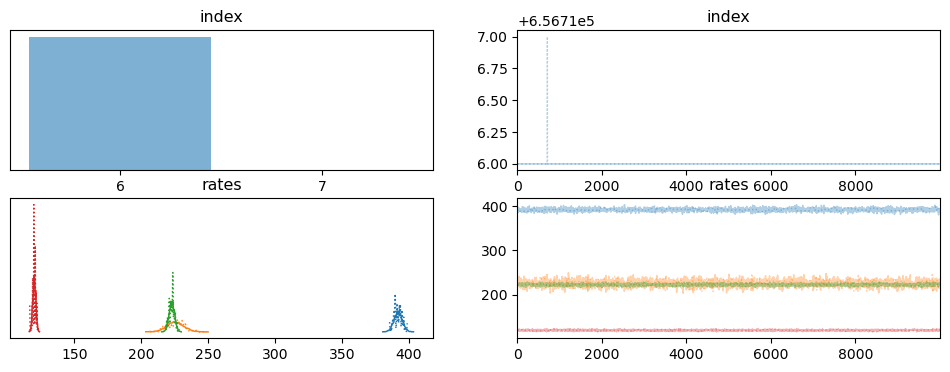

In [30]:
with zircons_model:
    #idata = pm.sample(10000)
    
    # Use slice sampler for means
    step1 = pm.Metropolis([rates])
    # Use Metropolis for switchpoint, since it accommodates discrete variables
    step2 = pm.Metropolis([index])

    # Initial values for stochastic nodes
    start = {"rates": (2.0 , 2.0 , 2.0)}

    #tr = pm.sample(1000, tune=500, start=start, step=[step1, step2], cores=1)
    #tr = pm.sample(start=start, step=[step1, step2],cores = 1)
    tr = pm.sample(tune = 10000, draws = 10000, step=[step1, step2],cores = 1)
    #az.plot_trace(tr)
    az.plot_trace(tr)

In [31]:
az.summary(tr)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
index,656716.000,0.016,656716.000,656716.000,0.000,0.000,4002.0,4002.0,1.00
rates[0],391.789,2.995,386.173,397.030,0.141,0.100,457.0,354.0,1.00
rates[1],225.624,6.548,213.833,237.855,0.237,0.168,763.0,738.0,1.00
rates[2],222.836,2.017,218.841,226.276,0.114,0.080,326.0,334.0,1.01
rates[3],120.059,1.148,118.149,122.252,0.071,0.051,280.0,192.0,1.01


In [32]:
print(switchPointList[656716])

[42, 47, 101]
